# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_26', 'ORACLE.run1_20', 'ORACLE.run1_32', 'ORACLE.run1_8', 'ORACLE.run1_38', 'ORACLE.run1_50', 'ORACLE.run1_44', 'ORACLE.run1_14'}


{'ORACLE.run2_32', 'ORACLE.run2_44', 'ORACLE.run2_8', 'ORACLE.run2_38', 'ORACLE.run2_50', 'ORACLE.run2_14', 'ORACLE.run2_26', 'ORACLE.run2_20'}


tensor([[[ 3.1434e-03,  2.3804e-03, -3.1434e-03,  ..., -2.6246e-03,
           3.0519e-05, -4.3031e-03],
         [-1.9837e-03,  1.5564e-03,  3.2350e-03,  ..., -2.6856e-03,
          -4.7609e-03, -1.2207e-04]],

        [[ 1.5564e-03,  3.7233e-03, -2.5025e-03,  ..., -2.7161e-03,
           3.1434e-03, -9.1556e-05],
         [-1.3123e-03,  2.2279e-03,  1.1902e-03,  ..., -1.8006e-03,
          -3.5096e-03, -3.3570e-03]],

        [[-1.2207e-03, -2.4110e-03,  3.0519e-03,  ...,  2.5941e-03,
          -3.8148e-03, -1.3123e-03],
         [ 9.1556e-04, -3.2655e-03, -6.7141e-04,  ...,  2.7467e-03,
           2.4720e-03,  2.8382e-03]],

        ...,

        [[-1.5564e-03, -3.5707e-03,  1.5259e-03,  ...,  3.5707e-03,
           1.4954e-03,  3.9674e-03],
         [ 3.6927e-03,  2.4415e-04, -4.2421e-03,  ...,  2.1363e-04,
           4.4252e-03, -9.7659e-04]],

        [[ 1.8921e-03,  3.0519e-05, -2.7161e-03,  ..., -2.7467e-04,
           4.5778e-03,  2.7772e-03],
         [ 0.0000e+00,  4.0895e-0

In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 34.0327, train_label_loss: 2.9645, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 3336.9570, train_label_loss: 0.5518, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3362.2036, train_label_loss: 0.5476, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 3577.9625, train_label_loss: 0.5073, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 2975.1433, train_label_loss: 0.2736, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 2986.3729, train_label_loss: 0.2351, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 3060.5044, train_label_loss: 0.2555, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 2995.1125, train_label_loss: 0.4152, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 3004.4022, train_label_loss: 0.4984, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 2978.1593, train_label_loss: 0.2161, 


epoch: 1, source_val_acc_label: 0.6420, target_val_acc_label: 0.6524, source_val_label_loss: 110.6516, target_val_label_loss: 117.3287, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 2.7483, train_label_loss: 364.7686, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3514.1426, train_label_loss: 0.4853, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 3829.1113, train_label_loss: 2.9322, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 3643.1308, train_label_loss: 0.2368, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 3745.6192, train_label_loss: 0.3122, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3913.6471, train_label_loss: 0.4933, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3894.1355, train_label_loss: 0.2754, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 4013.0631, train_label_loss: 0.2621, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 3797.1866, train_label_loss: 0.1596, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 3802.7922, train_label_loss: 0.2683, 


epoch: 2, source_val_acc_label: 0.9122, target_val_acc_label: 0.9115, source_val_label_loss: 0.2645, target_val_label_loss: 0.3271, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.8050, train_label_loss: 0.1406, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 3048.8170, train_label_loss: 0.4496, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 3033.0240, train_label_loss: 0.1568, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 2978.4348, train_label_loss: 0.2657, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 3183.5608, train_label_loss: 0.1752, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3465.9891, train_label_loss: 0.2743, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 3508.3599, train_label_loss: 0.0618, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 3328.7267, train_label_loss: 0.0344, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 3412.0946, train_label_loss: 0.2538, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3419.0752, train_label_loss: 0.2211, 


epoch: 3, source_val_acc_label: 0.9169, target_val_acc_label: 0.9077, source_val_label_loss: 0.2488, target_val_label_loss: 0.3539, 


epoch: 4, [batch: 1 / 6720], examples_per_second: 3.1495, train_label_loss: 0.2054, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3026.4963, train_label_loss: 0.1754, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 2992.8033, train_label_loss: 0.2061, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 2984.8756, train_label_loss: 0.1830, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 2953.7695, train_label_loss: 0.4827, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3009.5499, train_label_loss: 0.5706, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 3010.1209, train_label_loss: 0.1969, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 2976.9709, train_label_loss: 0.2299, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 3157.4564, train_label_loss: 0.0500, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 3437.6460, train_label_loss: 0.0559, 


epoch: 4, source_val_acc_label: 0.9295, target_val_acc_label: 0.9158, source_val_label_loss: 0.2025, target_val_label_loss: 0.3086, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 3.1519, train_label_loss: 0.2536, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3395.2008, train_label_loss: 0.1279, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 3608.2189, train_label_loss: 0.1465, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 3475.3257, train_label_loss: 0.2911, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 3379.3386, train_label_loss: 0.0544, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3420.2086, train_label_loss: 0.1643, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3462.1110, train_label_loss: 0.1613, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 3398.0181, train_label_loss: 0.1466, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 3482.0649, train_label_loss: 0.0225, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 3405.7494, train_label_loss: 0.0807, 


epoch: 5, source_val_acc_label: 0.9415, target_val_acc_label: 0.9262, source_val_label_loss: 0.1772, target_val_label_loss: 0.2712, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 3.1117, train_label_loss: 0.1280, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 3422.8088, train_label_loss: 0.2931, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 3456.6879, train_label_loss: 0.0303, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 3412.2462, train_label_loss: 0.1714, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 3440.0934, train_label_loss: 0.0165, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 3388.9342, train_label_loss: 0.1671, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 3388.4506, train_label_loss: 0.0546, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 3437.6542, train_label_loss: 0.2388, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3356.9861, train_label_loss: 0.2876, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 3379.5059, train_label_loss: 0.1577, 


epoch: 6, source_val_acc_label: 0.9446, target_val_acc_label: 0.9276, source_val_label_loss: 0.1690, target_val_label_loss: 0.2983, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 3.4759, train_label_loss: 0.0868, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 4060.5181, train_label_loss: 0.1606, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 4480.6898, train_label_loss: 0.3137, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 4890.5686, train_label_loss: 0.3920, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 5057.1431, train_label_loss: 0.0353, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 4631.5312, train_label_loss: 0.2100, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 3856.8292, train_label_loss: 0.0442, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 3824.9765, train_label_loss: 0.0677, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 3948.0633, train_label_loss: 0.1340, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 3934.1016, train_label_loss: 0.0999, 


epoch: 7, source_val_acc_label: 0.9501, target_val_acc_label: 0.9330, source_val_label_loss: 0.1499, target_val_label_loss: 0.2812, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 3.9382, train_label_loss: 0.0473, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 3824.1221, train_label_loss: 0.1836, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 3893.1063, train_label_loss: 0.0583, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3902.2421, train_label_loss: 0.0955, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 3899.4808, train_label_loss: 0.3006, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 3896.3929, train_label_loss: 0.0059, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 3882.7677, train_label_loss: 0.2240, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 3886.5879, train_label_loss: 0.1081, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 3879.0495, train_label_loss: 0.1077, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 3815.3945, train_label_loss: 0.2946, 


epoch: 8, source_val_acc_label: 0.9522, target_val_acc_label: 0.9296, source_val_label_loss: 0.1466, target_val_label_loss: 0.2773, 


epoch: 9, [batch: 1 / 6720], examples_per_second: 3.9943, train_label_loss: 0.1904, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 4077.7982, train_label_loss: 0.2350, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 4005.1641, train_label_loss: 0.0332, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 4012.1095, train_label_loss: 0.3921, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 3942.4340, train_label_loss: 0.1927, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3963.1169, train_label_loss: 0.0604, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 3954.2897, train_label_loss: 0.0817, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 3894.5742, train_label_loss: 0.0111, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 4025.0574, train_label_loss: 0.0899, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 3996.9611, train_label_loss: 0.1691, 


epoch: 9, source_val_acc_label: 0.9516, target_val_acc_label: 0.9332, source_val_label_loss: 0.1409, target_val_label_loss: 0.2534, 


New best


epoch: 10, [batch: 1 / 6720], examples_per_second: 3.4120, train_label_loss: 0.0835, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 2986.2041, train_label_loss: 0.5135, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3094.4047, train_label_loss: 0.0370, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 2961.7987, train_label_loss: 0.0520, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 2954.1668, train_label_loss: 0.0914, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 2954.1775, train_label_loss: 0.0670, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 2958.1098, train_label_loss: 0.1595, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 2952.6844, train_label_loss: 0.1720, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 2950.7476, train_label_loss: 0.1351, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 2958.5996, train_label_loss: 0.0489, 


epoch: 10, source_val_acc_label: 0.9417, target_val_acc_label: 0.9259, source_val_label_loss: 2.3565, target_val_label_loss: 2.4480, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.8164, train_label_loss: 0.0868, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 2951.2091, train_label_loss: 0.0359, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 2992.9653, train_label_loss: 0.1571, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 3017.7528, train_label_loss: 0.1505, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3012.5566, train_label_loss: 0.0390, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 2976.3634, train_label_loss: 0.0860, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3097.2371, train_label_loss: 0.3026, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3430.7811, train_label_loss: 0.0829, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 3416.1946, train_label_loss: 0.0428, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3373.8591, train_label_loss: 0.0335, 


epoch: 11, source_val_acc_label: 0.9570, target_val_acc_label: 0.9351, source_val_label_loss: 0.1349, target_val_label_loss: 0.2580, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 3.2350, train_label_loss: 0.0245, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3950.3258, train_label_loss: 0.0624, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3487.5622, train_label_loss: 0.0896, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 2937.3869, train_label_loss: 0.0092, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 2945.6456, train_label_loss: 0.2015, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 2936.6599, train_label_loss: 0.0628, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 2988.5187, train_label_loss: 0.0795, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 3008.0979, train_label_loss: 0.0677, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 3037.3789, train_label_loss: 0.2133, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 2993.7597, train_label_loss: 0.0257, 


epoch: 12, source_val_acc_label: 0.9525, target_val_acc_label: 0.9312, source_val_label_loss: 0.1468, target_val_label_loss: 0.2740, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 2.7843, train_label_loss: 0.0288, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 2961.0497, train_label_loss: 0.0163, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 2949.9023, train_label_loss: 0.0329, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 2984.9141, train_label_loss: 0.0238, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3036.4546, train_label_loss: 0.0770, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 2998.8978, train_label_loss: 0.2588, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3015.3736, train_label_loss: 0.3665, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 2960.7812, train_label_loss: 0.0114, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3039.0210, train_label_loss: 0.2044, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 3044.5977, train_label_loss: 0.1201, 


epoch: 13, source_val_acc_label: 0.9563, target_val_acc_label: 0.9309, source_val_label_loss: 0.1385, target_val_label_loss: 0.2760, 


epoch: 14, [batch: 1 / 6720], examples_per_second: 2.9420, train_label_loss: 0.0154, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3415.4527, train_label_loss: 0.0504, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3440.6867, train_label_loss: 0.1031, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3438.1957, train_label_loss: 0.0054, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3463.5861, train_label_loss: 0.2285, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3492.3957, train_label_loss: 0.0914, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3919.7975, train_label_loss: 0.0478, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3912.6304, train_label_loss: 0.1003, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 2983.7528, train_label_loss: 0.0309, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 2941.4097, train_label_loss: 0.0957, 


epoch: 14, source_val_acc_label: 0.9469, target_val_acc_label: 0.9235, source_val_label_loss: 0.1582, target_val_label_loss: 0.2855, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 2.8062, train_label_loss: 0.1937, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 3077.5870, train_label_loss: 0.0513, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 3003.5572, train_label_loss: 0.0153, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 2991.9440, train_label_loss: 0.1105, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 2966.7203, train_label_loss: 0.1233, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 3003.5378, train_label_loss: 0.0822, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 2958.9090, train_label_loss: 0.0744, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 2998.0328, train_label_loss: 0.0839, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 2987.8212, train_label_loss: 0.1216, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 2957.0115, train_label_loss: 0.1552, 


epoch: 15, source_val_acc_label: 0.9592, target_val_acc_label: 0.9358, source_val_label_loss: 0.1263, target_val_label_loss: 0.2450, 


New best


epoch: 16, [batch: 1 / 6720], examples_per_second: 2.7787, train_label_loss: 0.2141, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 2962.1097, train_label_loss: 0.1110, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 3137.1097, train_label_loss: 0.0127, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 3441.3674, train_label_loss: 0.0212, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 3413.0511, train_label_loss: 0.0248, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 3429.6091, train_label_loss: 0.0949, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 3405.7908, train_label_loss: 0.0333, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 3473.5811, train_label_loss: 0.0069, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 3528.6897, train_label_loss: 0.0175, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 3915.8252, train_label_loss: 0.1042, 


epoch: 16, source_val_acc_label: 0.9535, target_val_acc_label: 0.9359, source_val_label_loss: 0.1395, target_val_label_loss: 0.2634, 


New best


epoch: 17, [batch: 1 / 6720], examples_per_second: 3.0811, train_label_loss: 0.0719, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 2983.8367, train_label_loss: 0.1229, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 2952.7949, train_label_loss: 0.0700, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 3013.6516, train_label_loss: 0.0138, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 3017.8375, train_label_loss: 0.2070, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 2983.6139, train_label_loss: 0.1994, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 2978.3574, train_label_loss: 0.0526, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 3000.4035, train_label_loss: 0.6203, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 3060.0159, train_label_loss: 0.0830, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 3032.7116, train_label_loss: 0.0596, 


epoch: 17, source_val_acc_label: 0.9562, target_val_acc_label: 0.9374, source_val_label_loss: 0.1326, target_val_label_loss: 0.2371, 


New best


epoch: 18, [batch: 1 / 6720], examples_per_second: 2.7958, train_label_loss: 0.0807, 


epoch: 18, [batch: 672 / 6720], examples_per_second: 2975.3611, train_label_loss: 0.0302, 


epoch: 18, [batch: 1344 / 6720], examples_per_second: 3041.7504, train_label_loss: 0.0105, 


epoch: 18, [batch: 2016 / 6720], examples_per_second: 2965.6095, train_label_loss: 0.0799, 


epoch: 18, [batch: 2688 / 6720], examples_per_second: 2947.6449, train_label_loss: 0.0368, 


epoch: 18, [batch: 3360 / 6720], examples_per_second: 3000.9774, train_label_loss: 0.1450, 


epoch: 18, [batch: 4032 / 6720], examples_per_second: 3034.5104, train_label_loss: 0.0603, 


epoch: 18, [batch: 4704 / 6720], examples_per_second: 3144.5683, train_label_loss: 0.1069, 


epoch: 18, [batch: 5376 / 6720], examples_per_second: 3411.6248, train_label_loss: 0.0800, 


epoch: 18, [batch: 6048 / 6720], examples_per_second: 3435.3621, train_label_loss: 0.1077, 


epoch: 18, source_val_acc_label: 0.9560, target_val_acc_label: 0.9358, source_val_label_loss: 0.1335, target_val_label_loss: 0.2404, 


epoch: 19, [batch: 1 / 6720], examples_per_second: 3.2282, train_label_loss: 0.0833, 


epoch: 19, [batch: 672 / 6720], examples_per_second: 3560.9607, train_label_loss: 0.0804, 


epoch: 19, [batch: 1344 / 6720], examples_per_second: 3835.8488, train_label_loss: 0.0953, 


epoch: 19, [batch: 2016 / 6720], examples_per_second: 3330.3704, train_label_loss: 0.2566, 


epoch: 19, [batch: 2688 / 6720], examples_per_second: 3027.1622, train_label_loss: 0.1575, 


epoch: 19, [batch: 3360 / 6720], examples_per_second: 2987.7906, train_label_loss: 0.0575, 


epoch: 19, [batch: 4032 / 6720], examples_per_second: 2979.1460, train_label_loss: 0.0428, 


epoch: 19, [batch: 4704 / 6720], examples_per_second: 3026.1323, train_label_loss: 0.2179, 


epoch: 19, [batch: 5376 / 6720], examples_per_second: 3057.0060, train_label_loss: 0.0704, 


epoch: 19, [batch: 6048 / 6720], examples_per_second: 2999.5530, train_label_loss: 0.0060, 


epoch: 19, source_val_acc_label: 0.9546, target_val_acc_label: 0.9342, source_val_label_loss: 0.1375, target_val_label_loss: 0.2524, 


epoch: 20, [batch: 1 / 6720], examples_per_second: 2.8340, train_label_loss: 0.0259, 


epoch: 20, [batch: 672 / 6720], examples_per_second: 3026.9052, train_label_loss: 0.0614, 


epoch: 20, [batch: 1344 / 6720], examples_per_second: 3011.3638, train_label_loss: 0.1295, 


epoch: 20, [batch: 2016 / 6720], examples_per_second: 2991.7864, train_label_loss: 0.0647, 


epoch: 20, [batch: 2688 / 6720], examples_per_second: 2958.0538, train_label_loss: 0.0022, 


epoch: 20, [batch: 3360 / 6720], examples_per_second: 2983.0669, train_label_loss: 0.2345, 


epoch: 20, [batch: 4032 / 6720], examples_per_second: 2965.5325, train_label_loss: 0.3106, 


epoch: 20, [batch: 4704 / 6720], examples_per_second: 2993.7362, train_label_loss: 0.0975, 


epoch: 20, [batch: 5376 / 6720], examples_per_second: 3011.5535, train_label_loss: 0.0473, 


epoch: 20, [batch: 6048 / 6720], examples_per_second: 2986.3366, train_label_loss: 0.1001, 


epoch: 20, source_val_acc_label: 0.9599, target_val_acc_label: 0.9351, source_val_label_loss: 0.1262, target_val_label_loss: 0.2622, 


epoch: 21, [batch: 1 / 6720], examples_per_second: 2.9767, train_label_loss: 0.0321, 


epoch: 21, [batch: 672 / 6720], examples_per_second: 3352.5989, train_label_loss: 0.0730, 


epoch: 21, [batch: 1344 / 6720], examples_per_second: 3385.1813, train_label_loss: 0.0431, 


epoch: 21, [batch: 2016 / 6720], examples_per_second: 3442.8252, train_label_loss: 0.1398, 


epoch: 21, [batch: 2688 / 6720], examples_per_second: 3567.1084, train_label_loss: 0.0068, 


epoch: 21, [batch: 3360 / 6720], examples_per_second: 3851.0352, train_label_loss: 0.1822, 


epoch: 21, [batch: 4032 / 6720], examples_per_second: 3862.5013, train_label_loss: 0.0081, 


epoch: 21, [batch: 4704 / 6720], examples_per_second: 3015.5770, train_label_loss: 0.1099, 


epoch: 21, [batch: 5376 / 6720], examples_per_second: 3006.6911, train_label_loss: 0.0207, 


epoch: 21, [batch: 6048 / 6720], examples_per_second: 2968.0836, train_label_loss: 0.1299, 


epoch: 21, source_val_acc_label: 0.9569, target_val_acc_label: 0.9341, source_val_label_loss: 0.1342, target_val_label_loss: 0.2537, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

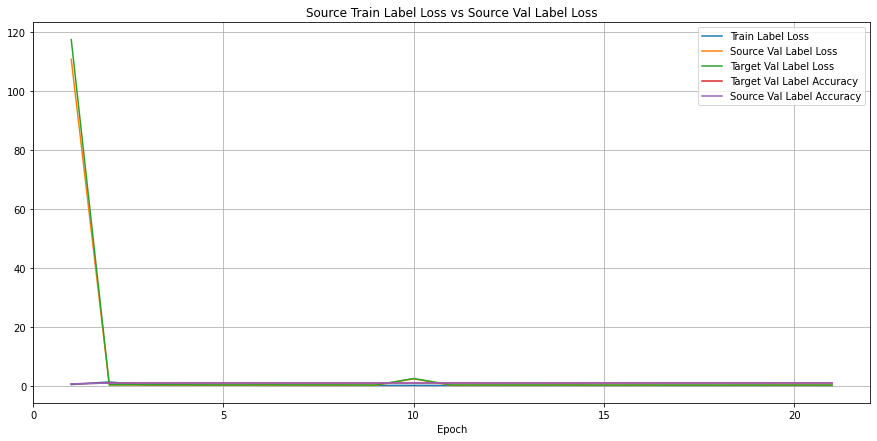

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

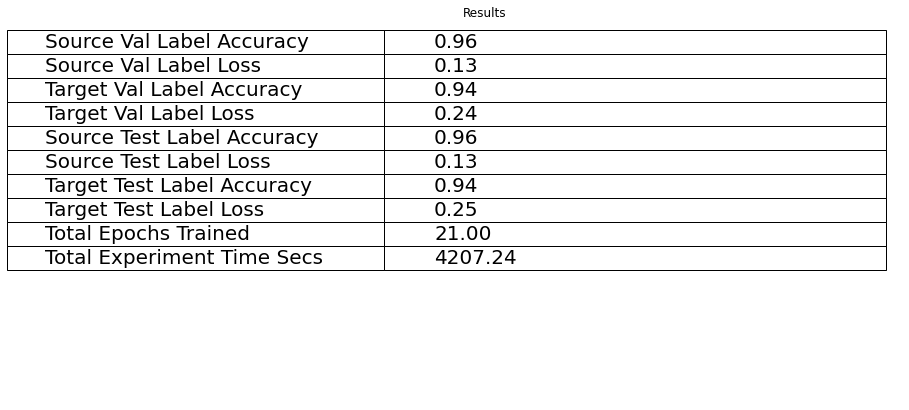

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

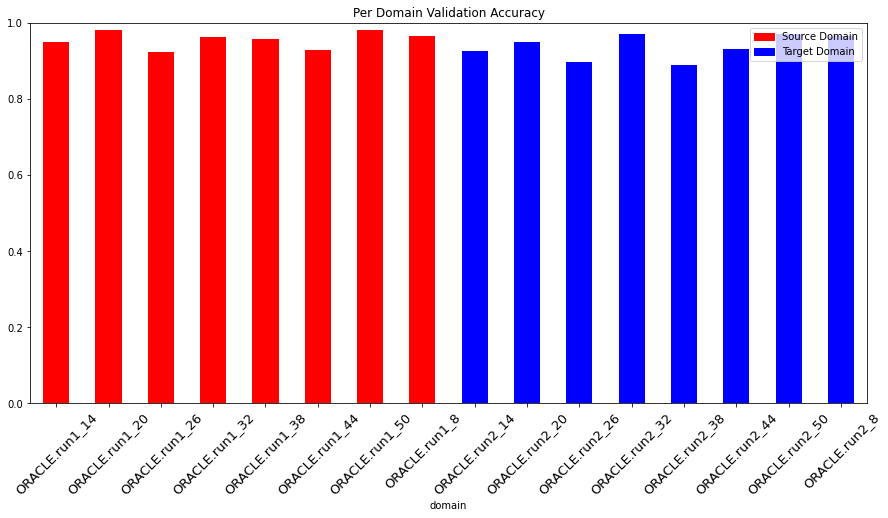

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9569986979166667 Target Test Label Accuracy: 0.9372721354166667
Source Val Label Accuracy: 0.9562174479166666 Target Val Label Accuracy: 0.9374348958333333


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 2048